The purpose of this notebook is to develop architecture and utilities for fit neural network on B → J reconstruction problem.

In [12]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from IPython.display import display, clear_output

In [14]:
import sys
sys.path.append('../../..')

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from magrec.prop.Fourier import FourierTransform2d
from magrec.prop.Kernel import HarmonicFunctionComponentsKernel, MagneticFieldToCurrentInversion2d
from magrec.prop.Propagator import CurrentPropagator2d, AxisProjectionPropagator
from magrec.misc.plot import plot_n_components
from magrec.nn.arch import GeneratorCNN
from magrec import __datapath__

In [16]:
from magrec.misc.load import load_matlab_data

In [17]:
# experimental data where three components of the magnetic field are measured above an Nb wire
# data is from DOI: 10.1103/PhysRevApplied.14.024076
Bx = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "Bx.txt")
By = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "By.txt")
Bz = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "Bz.txt")

B = torch.tensor(np.array([Bx, By, Bz]), dtype=torch.float32)

dx = 0.408  # in μm
dy = 0.408

height = 0.015          # μm
layer_thickness = 0.030 # μm

# this is an axis along which the magnetic field is *usually* measured
# in this case we will project the measured components to simulate such case
theta = 54.7            # degrees
phi = 45.0              # degrees

# Neural net architecture

In [18]:
from magrec.prop.Pipeline import (
    Pipe,
    HannFilter, 
    GaussianFilter,
    Union, 
    PlotResults, 
    FourierZeroDivergenceConstraint2d, 
    CurrentLayerToField, 
    Projection, 
    Sandwich, 
    Padder, 
    Function,
)

from magrec.scripts.prototype_pipeline import Prototype

from magrec.nn.arch import UNet, BnCNN

In [19]:
from magrec.scripts.prototype_pipeline import Prototype

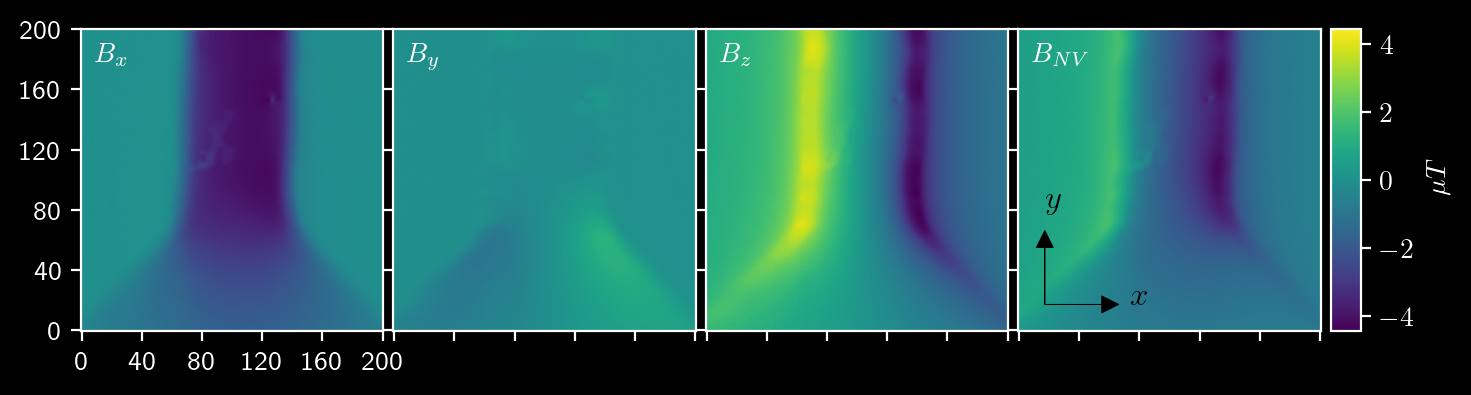

In [56]:
pipe = Pipe([  
    # NV stands for nitrogen-vacancy (its a quantum defect in diamond crystal used for measuring magnetic field and quantum computing)
    ('B+B_NV', Union([
        ('B', 'passthrough'),
        ('B_NV', Projection(theta=theta, phi=phi)),
    ], dim=-3)),
    ('plot1', PlotResults(labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], units=r"$\mu T$")),
    ('B_NV', Function(lambda x: x[None, [-1], :, :])),
    ('padded_B_NV', Padder(up_to=(16*20, 16*20))),
])

pipe.fit(B).transform(B);

threshold = -0.2

mask = pipe['padded_B_NV'].transform(
    torch.where(B[0] < threshold, torch.ones_like(B[0]), torch.zeros_like(B[0]))
    )

model = Pipe([
    # ('JxJy', Union([('Jx', FourierZeroDivergenceConstraint2d()), ('Jy', 'passthrough')], dim=-3)),
    ('maskJxJy', Function(lambda x: x * mask)),
    ('plot1', PlotResults(labels=[r"$J_x$", r"$J_y$"], units=r"mA/m$^2$")),
    ('B', CurrentLayerToField(dx=dx, dy=dy, height=height, layer_thickness=layer_thickness)),
    ('B+B_NV', Union([('B', 'passthrough'), ('B_NV', Projection(theta=theta, phi=phi))], dim=-3)),
    ('plot2', PlotResults(labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], units=r"$\mu T$")),
    ('B_NV', Function(lambda x: x[..., [-1], :, :])),
])

recon = Prototype(
    net=BnCNN, 
    model=model, 
    pipe=pipe, 
    max_epochs=20, 
    n_channels_in=1, 
    n_channels_out=2
    )

  epoch    train_loss       dur
-------  ------------  --------
    201      3.81e-01  2.21e-01
    220      1.85e-01  1.43e-01


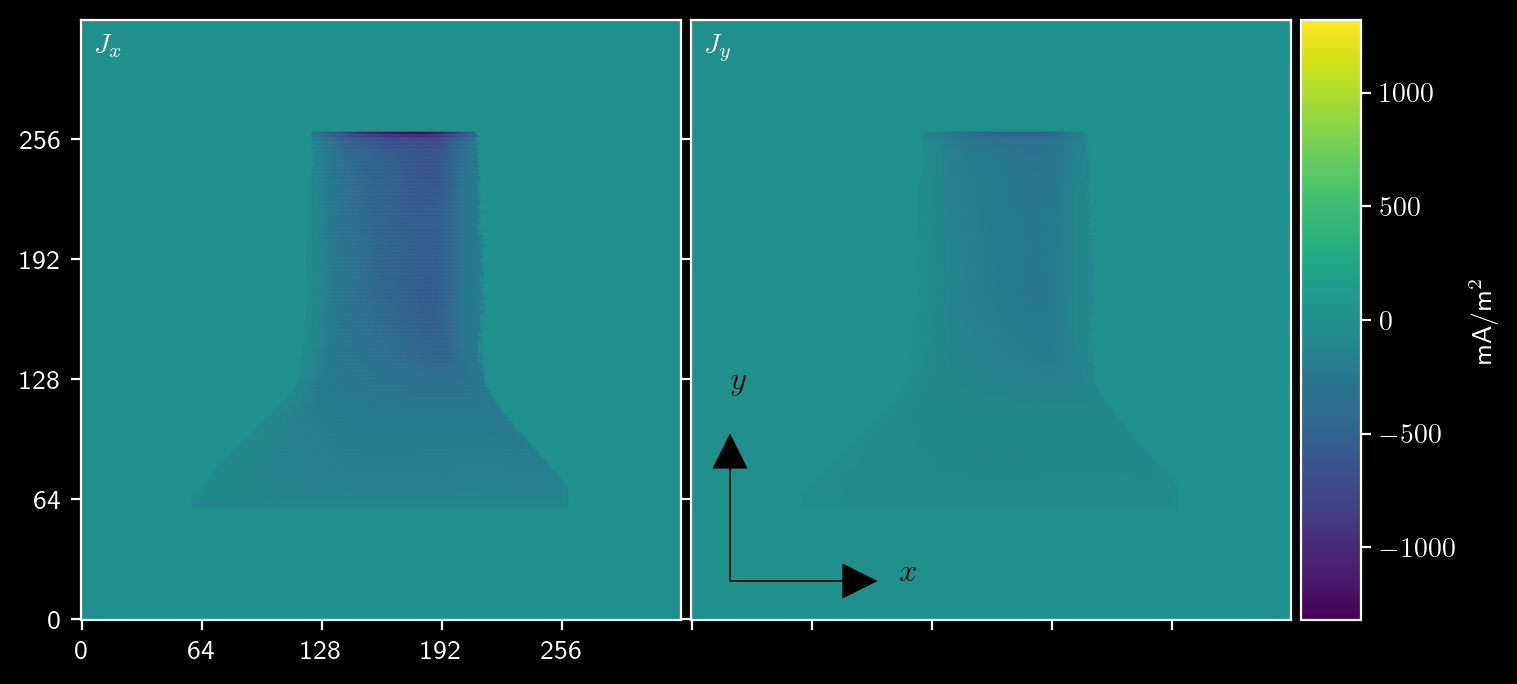

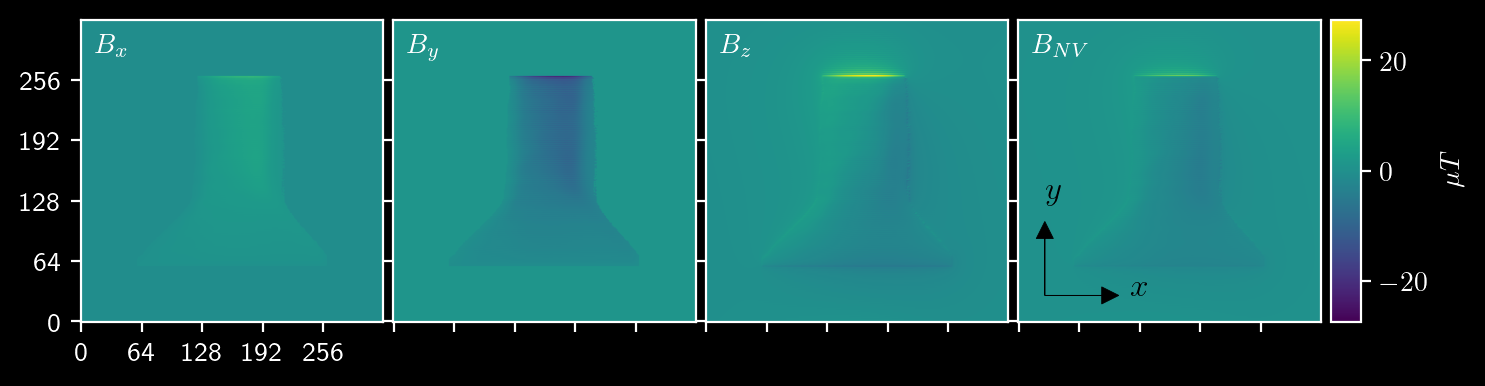

tensor([[[[0.3412, 0.3392, 0.3372,  ..., 0.3473, 0.3453, 0.3433],
          [0.3433, 0.3413, 0.3393,  ..., 0.3493, 0.3474, 0.3453],
          [0.3454, 0.3434, 0.3414,  ..., 0.3514, 0.3494, 0.3474],
          ...,
          [0.3349, 0.3329, 0.3308,  ..., 0.3411, 0.3391, 0.3370],
          [0.3370, 0.3350, 0.3329,  ..., 0.3432, 0.3411, 0.3391],
          [0.3391, 0.3371, 0.3350,  ..., 0.3452, 0.3432, 0.3412]]]],
       grad_fn=<IndexBackward0>)

In [58]:
recon.propagate(B, epochs=20, print_log_every=20, callbacks__print_log__floatfmt=".2e", lr=0.1)

In [ ]:
W, H = 20, 25
pad = torch.nn.ConstantPad2d((10, 10, 10, 10), 0)
torch.where()

In [49]:
torch.rand(5, 5, 6)[..., slice(None), slice(None), slice(4, 6)].shape

torch.Size([5, 5, 2])